In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
dataset,info=tfds.load('StanfordDogs', as_supervised=True,with_info=True)

2022-10-09 14:46:19.607263: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


2022-10-09 14:47:01.274081: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-09 14:47:01.367399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-09 14:47:01.368234: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-09 14:47:01.370370: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [3]:
batch_size=32
data_size=info.splits['train'].num_examples
class_names=info.features['label'].names
n_classes=info.features['label'].num_classes
test_size=info.splits['test'].num_examples

In [4]:
test_set,valid_set,train_set=tfds.load(
    'StanfordDogs',
    as_supervised=True,
    split=['test','train[:20%]','train[20%:]']
)

2022-10-09 14:47:04.027874: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


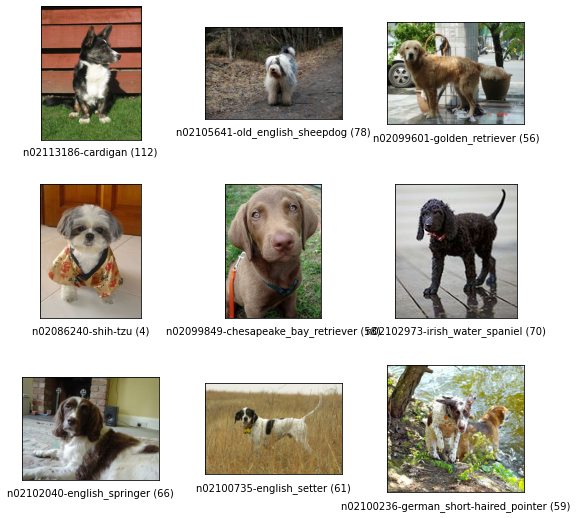

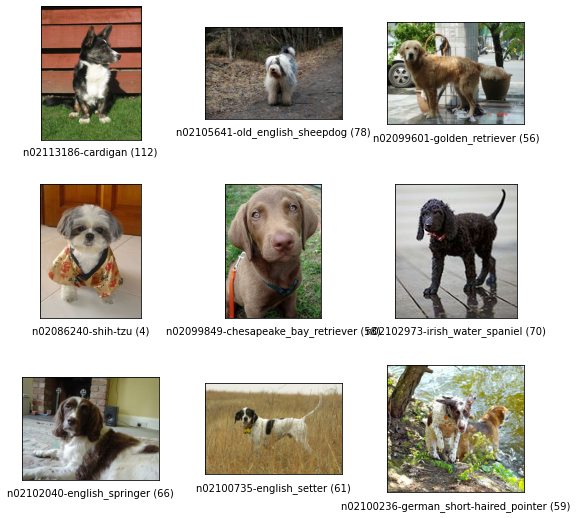

In [5]:
tfds.visualization.show_examples(train_set,info)

# Preprocessing data

In [6]:
def preprocess(image,label):
    resized_image=tf.image.resize(image,[299,299])
    final_image=keras.applications.xception.preprocess_input(resized_image)
    return final_image,label

In [7]:
train_set=train_set.shuffle(1000)
train_set=train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set=valid_set.map(preprocess).batch(batch_size).prefetch(1)
test_set=test_set.map(preprocess).batch(batch_size).prefetch(1)

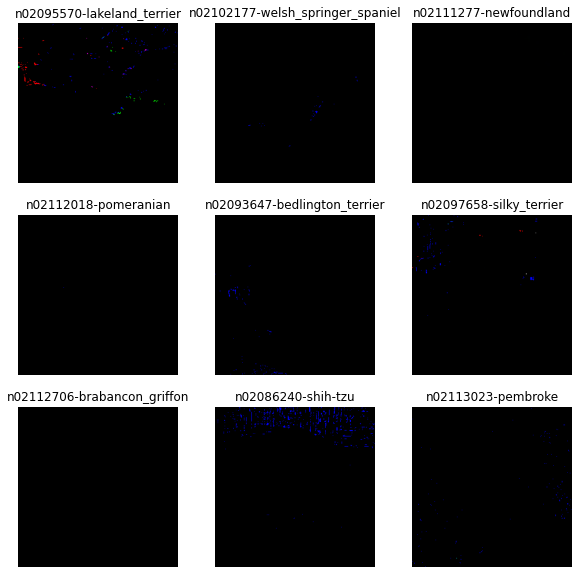

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Building model using transfer learning from ResNet50 model

In [9]:
base_model=keras.applications.xception.Xception(weights='imagenet',include_top=False)
avg=keras.layers.GlobalAveragePooling2D()(base_model.output)
output=keras.layers.Dense(n_classes,activation="softmax")(avg)
model=keras.Model(inputs=base_model.input,outputs=output)

83697664/83683744 [==============================] - 0s 0us/step


In [10]:
for layer in base_model.layers:
    layer.trainable=False

In [11]:
optimizer=keras.optimizers.SGD(learning_rate=0.2,momentum=0.9,decay=0.01)
rmsprop=keras.optimizers.RMSprop(learning_rate=0.1,rho=0.9)
model.compile(loss='sparse_categorical_crossentropy',optimizer=rmsprop,metrics=['accuracy'])
early_stopping=keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

In [12]:
history=model.fit(train_set,epochs=10,validation_data=valid_set,callbacks=[early_stopping])

Epoch 1/10


2022-10-09 14:47:15.854726: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


118/300 [==========>...................] - ETA: 23s - loss: 10.5214 - accuracy: 0.6160

Cleanup called...


300/300 [==============================] - 59s 164ms/step - loss: 7.4023 - accuracy: 0.7277 - val_loss: 6.5100 - val_accuracy: 0.7900
Epoch 2/10
119/300 [==========>...................] - ETA: 23s - loss: 4.2055 - accuracy: 0.8493

Cleanup called...


300/300 [==============================] - 49s 160ms/step - loss: 3.8878 - accuracy: 0.8554 - val_loss: 5.8738 - val_accuracy: 0.8246
Epoch 3/10
119/300 [==========>...................] - ETA: 23s - loss: 3.5449 - accuracy: 0.8700

Cleanup called...


300/300 [==============================] - 49s 161ms/step - loss: 3.1817 - accuracy: 0.8821 - val_loss: 5.3186 - val_accuracy: 0.8462
Epoch 4/10
119/300 [==========>...................] - ETA: 23s - loss: 2.5441 - accuracy: 0.8986

Cleanup called...


300/300 [==============================] - 49s 161ms/step - loss: 2.4617 - accuracy: 0.9022 - val_loss: 6.0297 - val_accuracy: 0.8388
Epoch 5/10
119/300 [==========>...................] - ETA: 23s - loss: 2.2348 - accuracy: 0.9105

Cleanup called...


300/300 [==============================] - 49s 161ms/step - loss: 2.2176 - accuracy: 0.9131 - val_loss: 5.8419 - val_accuracy: 0.8579
Epoch 6/10
118/300 [==========>...................] - ETA: 23s - loss: 1.6772 - accuracy: 0.9235

Cleanup called...


300/300 [==============================] - 49s 160ms/step - loss: 1.7088 - accuracy: 0.9260 - val_loss: 5.9221 - val_accuracy: 0.8508
Epoch 7/10
119/300 [==========>...................] - ETA: 23s - loss: 1.6247 - accuracy: 0.9273

Cleanup called...


300/300 [==============================] - 49s 161ms/step - loss: 1.5440 - accuracy: 0.9317 - val_loss: 5.8222 - val_accuracy: 0.8612
Epoch 8/10
119/300 [==========>...................] - ETA: 23s - loss: 1.2472 - accuracy: 0.9407

Cleanup called...


300/300 [==============================] - 49s 162ms/step - loss: 1.2022 - accuracy: 0.9407 - val_loss: 6.5332 - val_accuracy: 0.8521


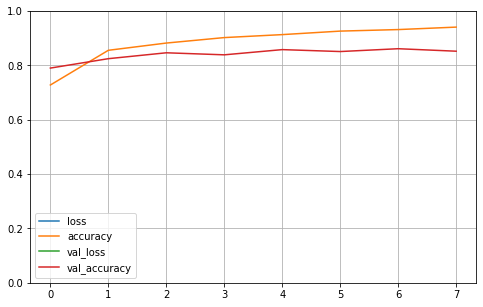

In [13]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [14]:
for layer in base_model.layers:
  layer.trainable=True

In [15]:
optimizer=keras.optimizers.SGD(learning_rate=0.01,momentum=0.9,decay=0.001,nesterov=True)
rmsprop=keras.optimizers.RMSprop(learning_rate=2e-4,rho=0.9)
history=model.fit(train_set,epochs=200,validation_data=valid_set,callbacks=[early_stopping])

Epoch 1/200
119/300 [==========>...................] - ETA: 23s - loss: 2.5681 - accuracy: 0.8947

Cleanup called...


300/300 [==============================] - 50s 162ms/step - loss: 2.5184 - accuracy: 0.9017 - val_loss: 5.1651 - val_accuracy: 0.8571
Epoch 2/200
119/300 [==========>...................] - ETA: 23s - loss: 2.0274 - accuracy: 0.9126

Cleanup called...


300/300 [==============================] - 49s 161ms/step - loss: 2.0417 - accuracy: 0.9169 - val_loss: 5.5674 - val_accuracy: 0.8525
Epoch 3/200
119/300 [==========>...................] - ETA: 23s - loss: 1.7150 - accuracy: 0.9254

Cleanup called...


300/300 [==============================] - 50s 162ms/step - loss: 1.6685 - accuracy: 0.9255 - val_loss: 6.1678 - val_accuracy: 0.8487
Epoch 4/200
119/300 [==========>...................] - ETA: 23s - loss: 1.4478 - accuracy: 0.9354

Cleanup called...


300/300 [==============================] - 50s 161ms/step - loss: 1.4590 - accuracy: 0.9365 - val_loss: 6.0814 - val_accuracy: 0.8579
Epoch 5/200
118/300 [==========>...................] - ETA: 23s - loss: 1.2869 - accuracy: 0.9401

Cleanup called...


300/300 [==============================] - 49s 162ms/step - loss: 1.3228 - accuracy: 0.9388 - val_loss: 5.8983 - val_accuracy: 0.8625
Epoch 6/200
120/300 [===========>..................] - ETA: 23s - loss: 1.1121 - accuracy: 0.9469

Cleanup called...


300/300 [==============================] - 49s 161ms/step - loss: 1.0713 - accuracy: 0.9481 - val_loss: 6.2463 - val_accuracy: 0.8571


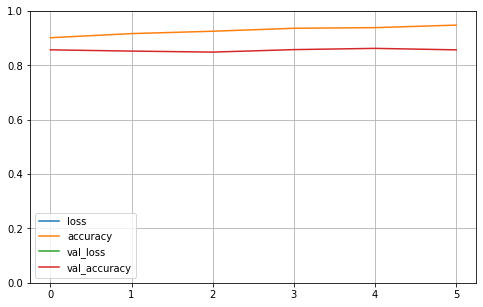

In [16]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [17]:
model.evaluate(test_set)

269/269 [==============================] - 35s 128ms/step - loss: 4.9500 - accuracy: 0.8657


[4.9500017166137695, 0.8657342791557312]

In [18]:
y_pred=model.predict(test_set)

In [19]:
unbatched_test=test_set.unbatch()

In [20]:
false_pred={class_name:0 for class_name in class_names}
true_pred={class_name:0 for class_name in class_names}
top_1=0
top_5=0
for pred,(images,label) in zip(y_pred,unbatched_test):
    if np.argmax(pred)!=label.numpy():
        false_pred[class_names[label.numpy()]]=false_pred[class_names[label.numpy()]]+1
        if label.numpy() in np.argpartition(pred, -4)[-4:]:
            top_5+=1
    else:
        top_5+=1
        top_1+=1
        true_pred[class_names[label.numpy()]]=true_pred[class_names[label.numpy()]]+1

In [21]:
benchmark=pd.DataFrame(data={'true_pred':true_pred.values(),'false_pred':false_pred.values()},index=class_names)

In [22]:
benchmark['% bad_prediction']=np.int64(benchmark.false_pred*100/(benchmark.true_pred+benchmark.false_pred))
benchmark['% good_prediction']=np.int64(benchmark.true_pred*100/(benchmark.true_pred+benchmark.false_pred))

In [23]:
benchmark

,true_pred,false_pred,% bad_prediction,% good_prediction
n02085620-chihuahua,39,13,25,75
n02085782-japanese_spaniel,78,7,8,91
n02085936-maltese_dog,133,19,12,87
n02086079-pekinese,36,13,26,73
n02086240-shih-tzu,86,28,24,75
...,...,...,...,...
n02113799-standard_poodle,39,20,33,66
n02113978-mexican_hairless,55,0,0,100
n02115641-dingo,51,5,8,91
n02115913-dhole,47,3,6,94


In [24]:
benchmark.nlargest(5,'% bad_prediction')

,true_pred,false_pred,% bad_prediction,% good_prediction
n02109961-eskimo_dog,2,48,96,4
n02098413-lhasa,30,56,65,34
n02105855-shetland_sheepdog,30,27,47,52
n02090379-redbone,27,21,43,56
n02113624-toy_poodle,29,22,43,56


In [25]:
benchmark.nlargest(5,'% good_prediction')

,true_pred,false_pred,% bad_prediction,% good_prediction
n02093647-bedlington_terrier,82,0,0,100
n02108915-french_bulldog,59,0,0,100
n02112350-keeshond,58,0,0,100
n02113978-mexican_hairless,55,0,0,100
n02116738-african_hunting_dog,69,0,0,100


In [26]:
print('TOP 1 ACCURACY:',top_1/test_size)
print('TOP 5 ACCURACY:',top_5/test_size)

TOP 1 ACCURACY: 0.8657342657342657
TOP 5 ACCURACY: 0.9748251748251748


In [27]:
model.save('dog_classif_model.h5', include_optimizer=False)

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [28]:
model_2=keras.models.load_model('dog_classif_model.h5')

In [29]:
np.savetxt("class_names.csv", np.array(class_names,dtype='str'),delimiter=",",fmt='%s')

In [30]:
def preprocess_new(image):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.resnet50.preprocess_input(resized_image)
    return final_image

In [31]:
from PIL import Image
img=Image.open('../input/solos-data/chihuahua-2900362__480.jpg')
img_to_tensor = tf.convert_to_tensor(img)
a=preprocess_new(img_to_tensor)
prediction=model(a.numpy().reshape(1,224,224,3),training=False)

In [32]:
class_names[np.argmax(prediction)]

'n02116738-african_hunting_dog'